# Hourly Bandwidth Prediction
This notebook predicts bandwidth usage per hour using time series features.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
plt.style.use('fivethirtyeight')
sns.set()

In [ ]:
# Load and prepare data
df = pd.read_csv('/content/Robi_DHAKA3_with_weekend_flag.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')
df = df.sort_index()
df.head()

,Gbps,is_weekend,is_holiday,is_event,is_political_gathering,is_powercut
Timestamp,,,,,,
2025-04-02 12:35:00,201.52,0,0,0,0,0
2025-04-02 14:14:00,200.64,0,0,0,0,0
2025-04-02 15:53:00,199.76,0,0,0,0,0
2025-04-02 17:32:00,198.00,0,0,0,0,0
2025-04-02 19:11:00,213.84,0,0,0,0,0


In [ ]:
# Feature engineering for hourly prediction
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['day'] = df.index.day
df['month'] = df.index.month
df['is_weekend'] = df['is_weekend'].astype(int)#df.index.weekday.astype(int)
df['is_holiday'] = df['is_holiday'].astype(int)
df['is_political_gathering'] = df['is_political_gathering'].astype(int)
df['is_event'] = df['is_event'].astype(int)
df['is_powercut']=df['is_powercut'].astype(int)

# Lag features (For Autocorrelation in Time-series Data)
df['lag_1'] = df['Gbps'].shift(1) #value from 1 hour ago
df['lag_2'] = df['Gbps'].shift(2) #value from 2 hour ago
df['lag_3'] = df['Gbps'].shift(3) #value from 3 hour ago
df['lag_24'] = df['Gbps'].shift(24)#value from 24 hour ago

# Rolling window features (Trend/volatility Detection)
df['rolling_mean_3'] = df['Gbps'].shift(1).rolling(window=3).mean() #mean of last 3 hour
df['rolling_std_3'] = df['Gbps'].shift(1).rolling(window=3).std() #standard deviation of last 3 hours
df['rolling_mean_24'] = df['Gbps'].shift(1).rolling(window=24).mean() #24 hour mean
df['rolling_std_24'] = df['Gbps'].shift(1).rolling(window=24).std() #24 hour standard deviation

# Drop NA
df = df.dropna()
df.head()

,Gbps,is_weekend,is_holiday,is_event,is_political_gathering,is_powercut,hour,dayofweek,day,month,lag_1,lag_2,lag_3,lag_24,rolling_mean_3,rolling_std_3,rolling_mean_24,rolling_std_24
Timestamp,,,,,,,,,,,,,,,,,,
2025-04-04 04:09:00,180.40,1,0,0,0,0,4,4,4,4,181.28,198.00,217.36,201.52,198.880000,18.056090,185.313333,39.303359
2025-04-04 05:48:00,68.64,1,0,0,0,0,5,4,4,4,180.40,181.28,198.00,200.64,186.560000,9.917096,184.433333,39.160896
2025-04-04 07:27:00,68.64,1,0,0,0,0,7,4,4,4,68.64,180.40,181.28,199.76,143.440000,64.780195,178.933333,45.536265
2025-04-04 09:06:00,101.20,1,0,0,0,0,9,4,4,4,68.64,68.64,180.40,198.00,105.893333,64.524666,173.470000,50.521713
2025-04-04 10:45:00,116.16,1,0,0,0,0,10,4,4,4,101.20,68.64,68.64,213.84,79.493333,18.798525,169.436667,52.310530


In [ ]:
# Train-test split
split_date = '2025-05-10'
train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

FEATURES = ['hour', 'dayofweek', 'day', 'month', 'is_weekend', 'is_holiday', 'is_political_gathering','is_event',
            'lag_1', 'lag_2', 'lag_3', 'lag_24',
            'rolling_mean_3', 'rolling_std_3', 'rolling_mean_24', 'rolling_std_24', 'is_powercut']
TARGET = 'Gbps'

X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
# Train XGBoost model
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predict
test['prediction'] = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(f'RMSE: {rmse:.4f}')

RMSE: 22.7179


/tmp/ipython-input-5-641167465.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(X_test)


On average the predictions are off by 22.7 Gbps

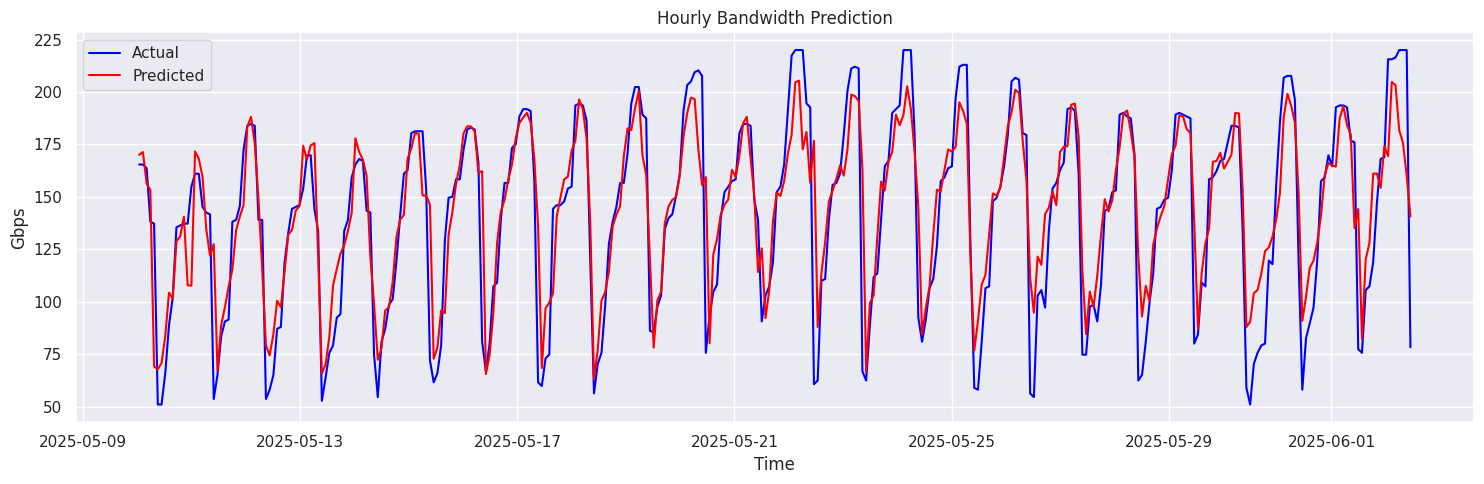

In [ ]:
# Plot hourly predictions
plt.figure(figsize=(15, 5))
plt.plot(test.index, y_test, label='Actual', color='blue')
plt.plot(test.index, test['prediction'], label='Predicted', color='red')
plt.title('Hourly Bandwidth Prediction')
plt.xlabel('Time')
plt.ylabel('Gbps')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

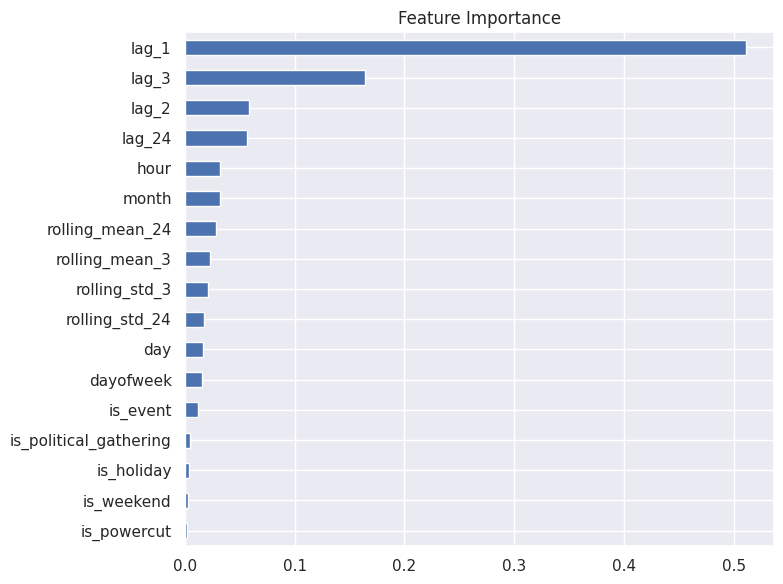

In [ ]:
# Feature importance plot
importances = model.feature_importances_ #Retrieve the feature importance score
feat_imp = pd.Series(importances, index=FEATURES).sort_values()
feat_imp.plot(kind='barh', title='Feature Importance', figsize=(8,6))
plt.tight_layout()
plt.show()

In [ ]:
model.save_model('bw_predictor.h5')

/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [09:36:35] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


In [ ]:
model.save_model('bw_predictor.json')